In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Apr_17_19:36:51_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.5, V12.5.40
Build cuda_12.5.r12.5/compiler.34177558_0


### Faz os imports e seta o diretório atual

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import ipynbname
import torch
from everywhereml.code_generators.tensorflow import tf_porter

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

nb_fname = ipynbname.name()
nb_path = ipynbname.path()

os.chdir('{0}/..'.format(os.path.split(nb_path)[0]))

from commands.commands import commands_list

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Cuda device: ", device)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Cuda device:  cpu
Num GPUs Available:  0


### Lê os arquivos no diretório data

In [2]:
DATASET_PATH = './data'

data_dir = pathlib.Path(DATASET_PATH)

command_audio_files = np.array(tf.io.gfile.listdir(str(data_dir)))
len(command_audio_files)

12985

### Lista os comandos

In [3]:
print(commands_list)
print(len(commands_list))

['Sim', 'Não', 'Cima', 'Baixo', 'Esquerda', 'Direita', 'Ligado', 'Desligado', 'Parar', 'Vai', 'Zero', 'Um', 'Dois', 'Três', 'Quatro', 'Cinco', 'Seis', 'Sete', 'Oito', 'Nove', 'Cama', 'Pássaro', 'Gato', 'Cachorro', 'Feliz', 'Casa', 'Marvin', 'Sheila', 'Árvore', 'Uau', 'Trás', 'Avançar', 'Seguir', 'Aprender', 'Visual']
35


### Número de samples

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*.*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print("Número de samples: ", num_samples)
print('Número de samples por label: ',
      len(tf.io.gfile.glob(str(data_dir) + '/'  + str(commands_list[0]) + '*.*')))

Número de samples:  12985
Número de samples por label:  371


### Decodifica o áudio

In [5]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Dropa um dos canais de áudio, caso o áudio seja estéreo
  return tf.squeeze(audio, axis=-1)

### Pega os labels do arquivos

In [6]:
split = tf.strings.split

def get_label(file_path):
  parts = split(input=file_path, sep=os.path.sep)[1]
  parts = split(parts, '_')[0]
  return parts

### Pega a forma de onda e o label correspondente

In [7]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


### Separa os arquivos para o treinamento

In [8]:
train_n = int(len(filenames)*(8/10)) ### 80% dos arquivos
train_t_v = int( (len(filenames) - train_n) / 2 )

train_files = filenames[:train_n] # 80% para treino
val_files = filenames[train_n: train_n + train_t_v] # 10% para validação
test_files = filenames[-train_t_v:] # 10% para teste

print("Número de arquivos para treino: ", len(train_files))
print("Número de arquivos para validação: ", len(val_files))
print("Número de arquivos para teste: ", len(test_files))

Número de arquivos para treino:  10388
Número de arquivos para validação:  1298
Número de arquivos para teste:  1298


### Cria um dataset a partir de train_files

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

### Exibe algumas formas de ondas

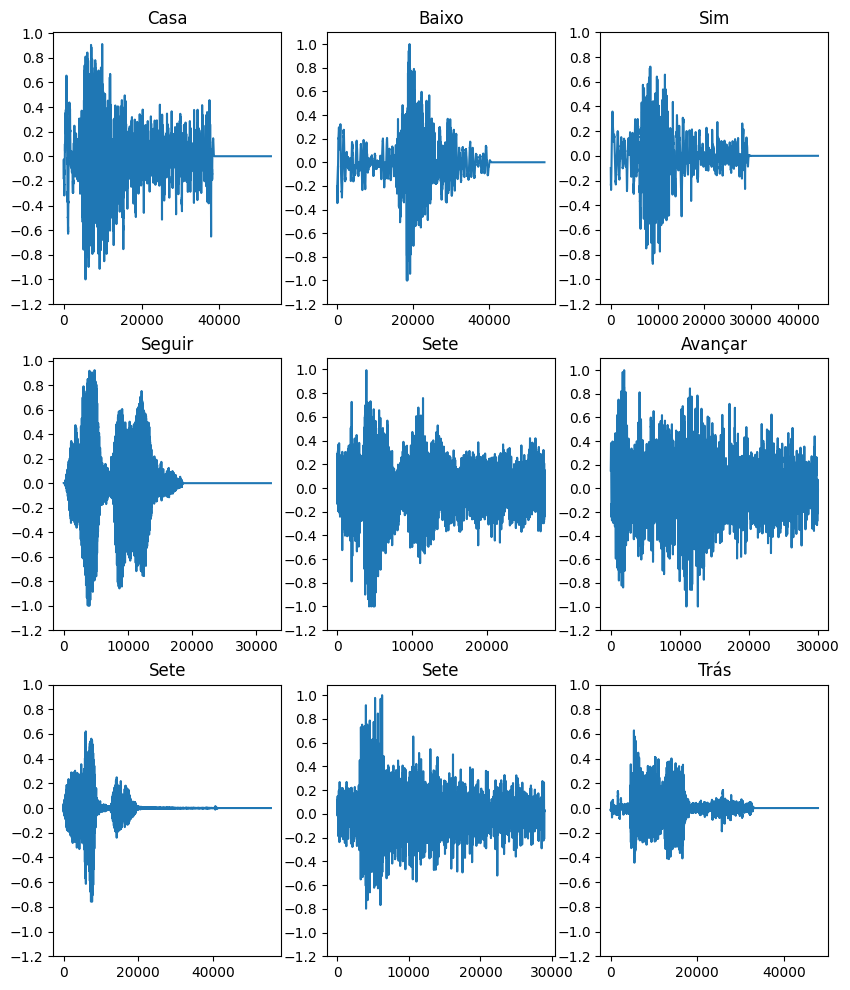

In [10]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### Converte a forma de onda em spectograma

In [11]:
def get_spectrogram(waveform):
  # 16,000 khz.
  input_len = 24000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [24000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### Fornece o áudio de um spectograma

In [12]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=24000))

Label: Casa
Waveform shape: (53264,)
Spectrogram shape: (186, 129, 1)
Audio playback


### Função para exibir o spectograma

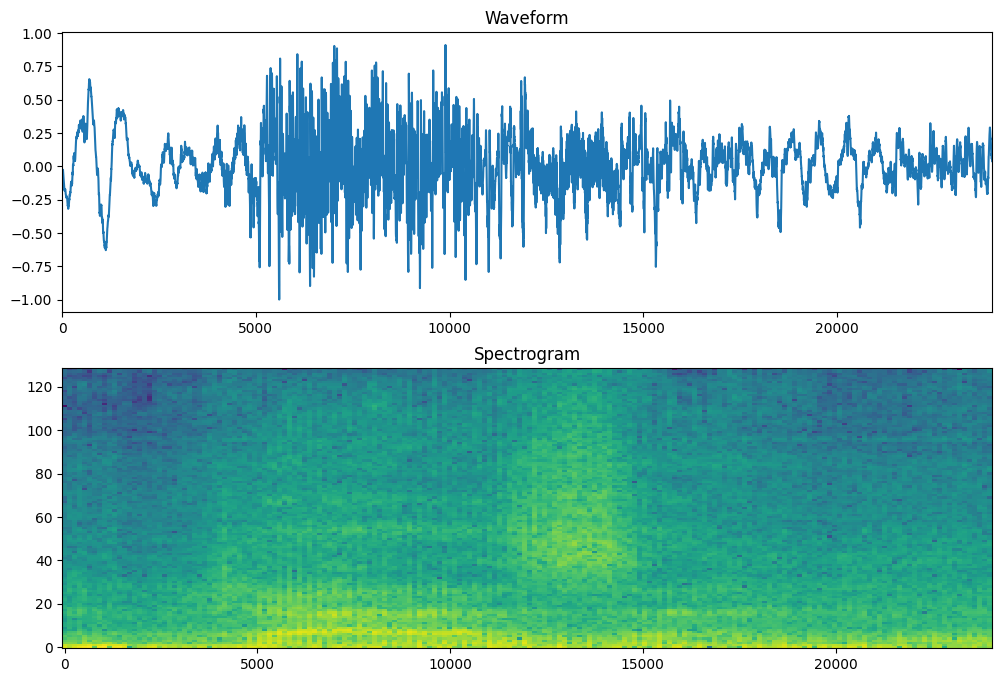

In [13]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 24000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

### Associa os spectogramas aos labels correspondentes:

In [14]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands_list)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

### Exibe alguns spectogramas

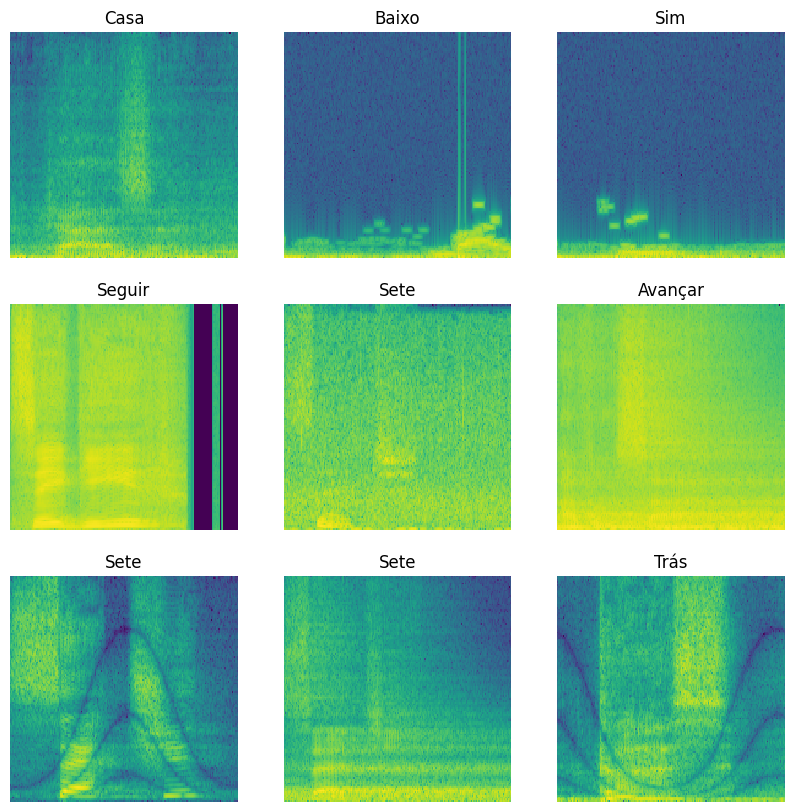

In [15]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands_list[label_id.numpy()])
  ax.axis('off')

plt.show()

### Pré processa os dados

In [16]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

### Agrupa os modelos e reduz a latência

In [17]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

### Cria o modelo:

In [20]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands_list)

norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (186, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,629,094 (6.21 MB)

 Trainable params: 1,629,091 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

### Compila o modelo com a otimização e a perda

In [23]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Treina o modelo e salva

In [24]:
EPOCHS = 12
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

if not os.path.exists("./checkpoints"): 
    os.makedirs("./checkpoints")

# model.save('./checkpoints/model.keras')

# model = tf.keras.models.load_model('./checkpoints/model.keras')
model.export("./temp/saved_model")



Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.1446 - loss: 3.2055 - val_accuracy: 0.5008 - val_loss: 1.8830
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4315 - loss: 2.0137 - val_accuracy: 0.6841 - val_loss: 1.2504
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5883 - loss: 1.4434 - val_accuracy: 0.7704 - val_loss: 0.9009
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6798 - loss: 1.0972 - val_accuracy: 0.8143 - val_loss: 0.7275
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7439 - loss: 0.8583 - val_accuracy: 0.8382 - val_loss: 0.6127
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7826 - loss: 0.7321 - val_accuracy: 0.8598 - val_loss: 0.5359
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8165 - loss: 0.5853 - val_accuracy: 0.8667 - val_loss: 0.4860
Epoch 8/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8449 - loss: 0.5013 - val_acc

INFO:tensorflow:Assets written to: ./temp/saved_model\assets


Saved artifact at './temp/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 186, 129, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 35), dtype=tf.float32, name=None)
Captures:
  2217948970640: TensorSpec(shape=(1, 1, 1), dtype=tf.float32, name=None)
  2217948970448: TensorSpec(shape=(1, 1, 1), dtype=tf.float32, name=None)
  2217948968720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2218017456784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2218017456976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2218017456400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2218017457168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2218017457936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2218017459088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2218017460048: TensorSpec(shape=(), dtype=tf.resource, name=None)


### Plot das curvas de perda e validação

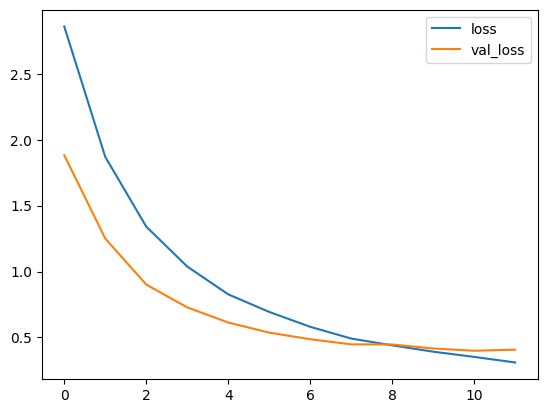

In [25]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Convertendo para Tensorflow Lite e fazendo uma predição neste modelo

In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model("./temp/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

sample_file = data_dir/'Não_carokowa.wav'

sample_ds = preprocess_dataset([str(sample_file)])

spectrogram = None

for s, label in sample_ds.batch(1):
    spectrogram = s
    
if not os.path.exists("./models"): 
    os.makedirs("./models")

with open("./models/model.tflite", "wb") as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

output = interpreter.get_output_details()
input = interpreter.get_input_details()

### Faz a inferência
interpreter.set_tensor(input[0]['index'], spectrogram)
interpreter.invoke()
output_data  = interpreter.get_tensor(output[0]['index']) # predict

val = np.argmax(output_data[0])

print(input_shape)
print(val)
print(commands_list[val])

[  1 186 129   1]
1
Não


### Validando o desempenho do modelo

In [30]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test set accuracy: 90%


### Exibindo a matrix de confusão

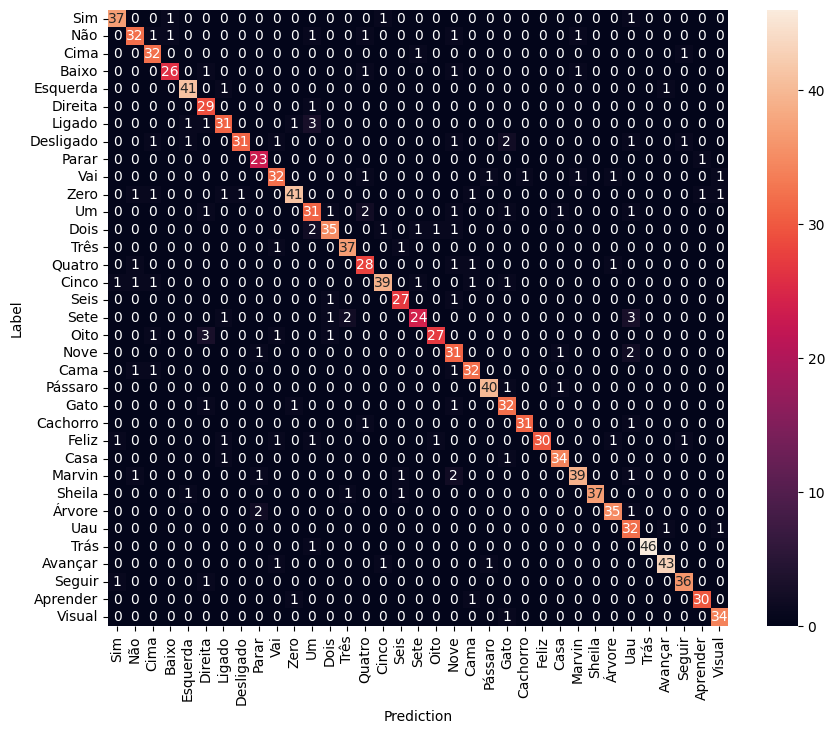

In [31]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands_list,
            yticklabels=commands_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Executando a inferência em um arquivo de áudio

In [19]:
sample_file = data_dir/'Aprender_carokowa.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()

NameError: name 'model' is not defined

### Executando outra inferência

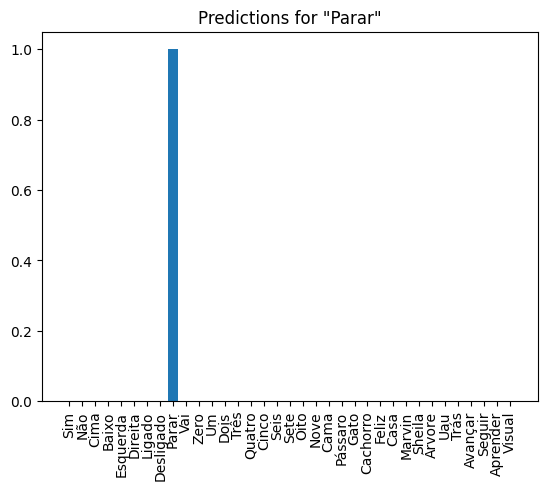

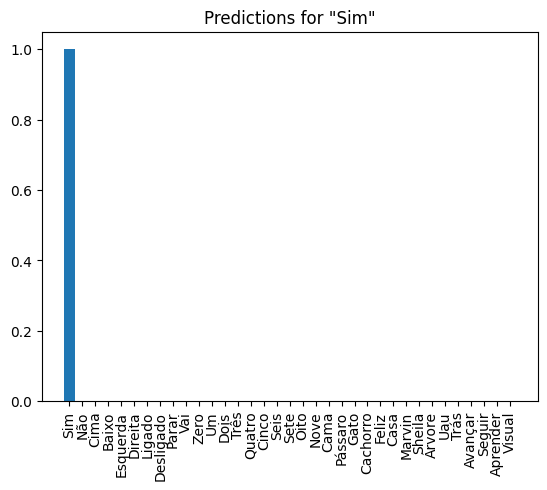

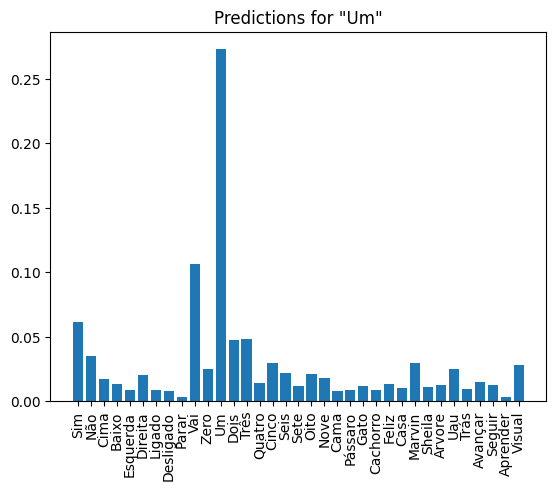

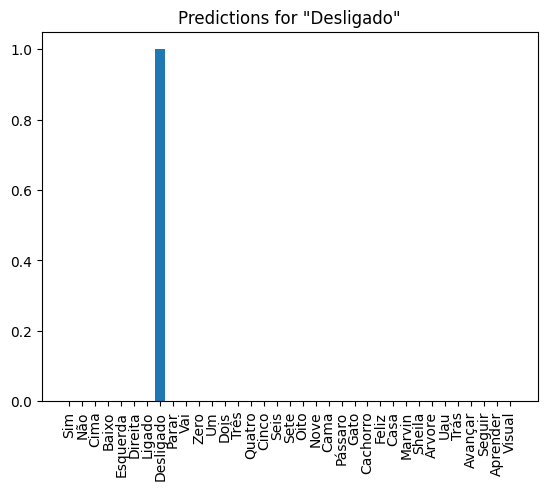

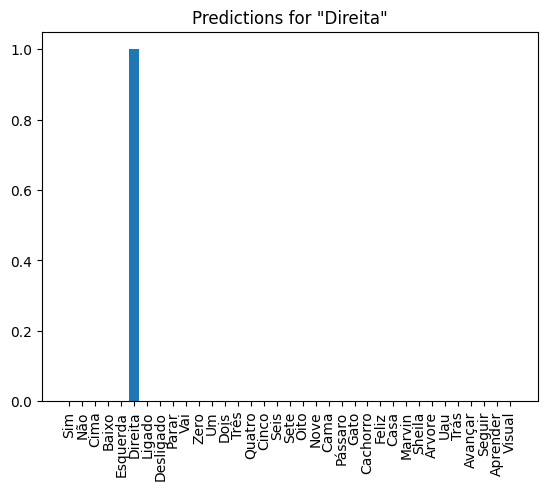

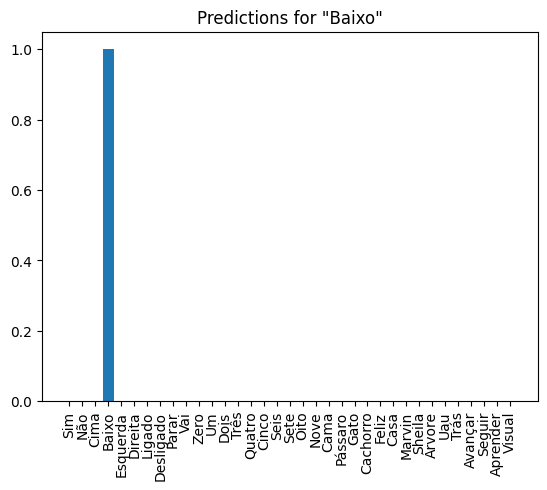

In [33]:
sample_file = data_dir/'Parar_krikor.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()

sample_file = data_dir/'Sim_aleatoriogps.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()

sample_file = data_dir/'Um_aleatoriogps.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()


sample_file = data_dir/'Desligado_aleatoriogps.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()

sample_file = data_dir/'Direita_oqmdv.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()

sample_file = data_dir/'Baixo_oqmdv.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()